## MRI-7T-teskfMRI

This notebook does event-related task-fMRI BOLD mapping on hippocmapal surfaces using Nilearn (https://nilearn.github.io/stable/index.html). This is done for 3 tasks: 1. the Mneumonic Similarity Task (MST), 2. Episodic Retreival, and 3. Episodic Encoding. Each task uses different raw data, which is (optionally) mapped to the hippocampus in step X.0. Analyses are then performed in steps X.1+.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
import hippomaps as hm
import os
import pickle
import csv, os
import pandas as pd
import nilearn
from nilearn import surface
from nilearn.glm.first_level import make_first_level_design_matrix, run_glm
from nilearn.glm.contrasts import compute_contrast
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels
from scipy.stats import ttest_1samp

In [2]:
# config

useCheckpoints = True # this will download and use checkpoint numpy array data instead of mapping local data to hippocampal surfaces 
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['MRI-7T-taskfMRI.npz'])
    
# 1. specify the subjects and directories
subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015','PNC016', 'PNC018','PNC019']
micapipe_dir = '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'
micapipe_raw = '/data/mica3/BIDS_PNI/rawdata'
hippunfold_dir='/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold'
tmp_dir = 'tmp_func'

# 2. Prepare data and analysis parameters 
ses = '01'
hemis = ['L','R']
labels= ['hipp']#,'dentate'] 
den = '2mm'
tasks= ['patternsep2', 'epiencode','epiretrieve']
t_r = 1.69 
slice_time_ref = 0.0
nVolumes=275 # Max timeseries length (will be padded with NaNs if the run is shorter)
sigma = 3 #Gaussian smoothing kernal sigma (mm)

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# 3. Load neocortical surfaces for visualzation
parcL, parcR = load_parcellation('schaefer')
parc = np.concatenate((parcL, parcR))
nP = len(np.unique(parcL))-1 # number of neocortical parcels (one hemisphere)
c69_inf_lh, c69_inf_rh = load_conte69()

# 0. Map all task data to hippocampal surface

In [3]:
if not useCheckpoints:
    !mkdir -p {tmp_dir}

    cdata_hipp = np.ones((nV,len(hemis),nVolumes,len(tasks),len(subs)))*np.nan
    neo_ts = np.ones((nP,len(hemis),nVolumes,len(tasks),len(subs)))
    all_events = np.empty(((len(tasks)),(len(subs))),dtype=object)
    all_motion_reg = np.empty(((len(tasks)),(len(subs))),dtype=object)

    for t,task in enumerate(tasks):
        sub_events = []
        sub_motion_reg = []

        for s,sub in enumerate(subs):

            # events and regressors
            all_events[t,s] = pd.read_table(f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_events.tsv')
            all_motion_reg[t,s] = np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-{task}_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')

            # convert affines 
            cmd1a = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
                f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-me_task-{task}_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
                f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
            !{cmd1a}
            cmd1b = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
                f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-{task}_bold_mode-image_desc-SyN_0GenericAffine.mat '\
                f'-inv '\
                f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
            !{cmd1b}

            for h,hemi in enumerate(hemis):
                for l,label in enumerate(labels):
                    #apply affines
                    cmd2a = f'wb_command -surface-apply-affine '\
                        f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                    !{cmd2a}
                    cmd2b = f'wb_command -surface-apply-affine '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                    !{cmd2b}

                    # apply warp (Note this is actually the INVERSE warp)
                    cmd3 = f'wb_command -surface-apply-warpfield '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-{task}_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                    !{cmd3}

                    # sample
                    cmd4 = f'wb_command -volume-to-surface-mapping '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-{task}_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                        f'-enclosing'
                    !{cmd4}

                    # smooth
                    cmd5 = f'wb_command -metric-smoothing '\
                        f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                        f'{sigma} '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii '
                    !{cmd5}

                    # load mapped hippocmapal surface data
                    func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii')
                    for k in range(len(func.darrays)):
                        cdata_hipp[iV[l],h,k,t,s] = func.darrays[k].data

                    # Load the neocortical timeseries in fsLR32k and dowmsample to schaefer 400 space
                    func = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-{task}_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
                    func_parc = np.ones((int(nP*2),nVolumes))*np.nan
                    for i in range(int(nP*2)):
                        for k in range(func.shape[0]):
                            func_parc[i,k] = np.nanmean(func[k, parc == (i + 1)])
                    neo_ts[:,:,:,t,s] = func_parc.reshape((nP,2,nVolumes))

    np.savez_compressed("../checkpoints/MRI-7T-taskfMRI", cdata_hipp, neo_ts, all_events, all_motion_reg)
    !rm -r {tmp_dir}

# 1. GLM fit pattern separation2

In [4]:
loaddat = np.load("../checkpoints/MRI-7T-taskfMRI.npz", allow_pickle=True)
cdata_hipp = loaddat['arr_0']
neo_ts = loaddat['arr_1']
all_events = loaddat['arr_2']
all_motion_reg = loaddat['arr_3']

In [ ]:
#list all possible combination of correct answer(target) and subject response 
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']

t = 0 # only look at data from the first task
contrasts_patternsep2 = np.ones((nV, len(hemis), len(subs), 6))*np.nan # 6 different contrasts will be considered
contrasts_patternsep2_neo = np.ones((nP, len(hemis), len(subs), 6)) * np.nan

for s,sub in enumerate(subs):
    
    ### create design matrix ###

    # Specify the timing of fmri frames 
    motion_reg = all_motion_reg[t,s]
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)
    events = all_events[t,s]
    # Recode events to include fixation, stimulus, key press/response to soak up variance
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time']]
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
    # Combine response and condition to get all possible combinations
    true_con = events['trial_type'] + events["response"].astype('str')
    df['trial_type'] = true_con
    
    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg)
    # in case of some trial types missing, add extras with all 0sL
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0    
            
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])
    contrasts = {
    'patternseparation_uncorrected': (
        basic_contrasts['similarsimilar']
        + basic_contrasts['similarsimilar_derivative']
        + basic_contrasts['similarsimilar_dispersion']),
    'patterncompletion_uncorrected': (
        basic_contrasts['oldsimilar']
        + basic_contrasts['oldsimilar_derivative']
        + basic_contrasts['oldsimilar_dispersion']),
    'noveltydetection_uncorrected': (
        basic_contrasts['newnew']
        + basic_contrasts['newnew_derivative']
        + basic_contrasts['newnew_dispersion']),
    'patternseparation': (
        basic_contrasts['similarsimilar']
        - basic_contrasts['similarnew']
        + basic_contrasts['similarsimilar_derivative']
        - basic_contrasts['similarnew_derivative']
        + basic_contrasts['similarsimilar_dispersion']
        - basic_contrasts['similarnew_dispersion']),
    'patterncompletion': (
        basic_contrasts['oldsimilar']
        - basic_contrasts['oldnew']
        + basic_contrasts['oldsimilar_derivative']
        - basic_contrasts['oldnew_derivative']
        + basic_contrasts['oldsimilar_dispersion']
        - basic_contrasts['oldnew_dispersion']),
    'noveltydetection': (
        basic_contrasts['newnew']
        - 0.5*basic_contrasts['oldsimilar']
        - 0.5*basic_contrasts['oldnew']
        + basic_contrasts['newnew_derivative']
        - 0.5*basic_contrasts['oldsimilar_derivative']
        - 0.5*basic_contrasts['oldnew_derivative']
        + basic_contrasts['newnew_dispersion']
        - 0.5*basic_contrasts['oldsimilar_dispersion']
        - 0.5*basic_contrasts['oldnew_dispersion'])}
    
    for h, hemi in enumerate(hemis):

        ### fit the design matrix to the data
        labels_, estimates = run_glm(cdata_hipp[:,h,:210,t,s].T, design_matrix.values[:210]) # the last part of the task block is simply rest, so we will cut it
        labels_neo, estimates_neo = run_glm(neo_ts[:,h,:210,t,s].T, design_matrix.values[:210]) # the last part of the task block is simply rest, so we will cut it

        ### run contrasts of interest
        for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
            contrasts_patternsep2[:, h, s, c] = contrast.z_score()
            contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
            contrasts_patternsep2_neo[:, h, s, c] = contrast.z_score()


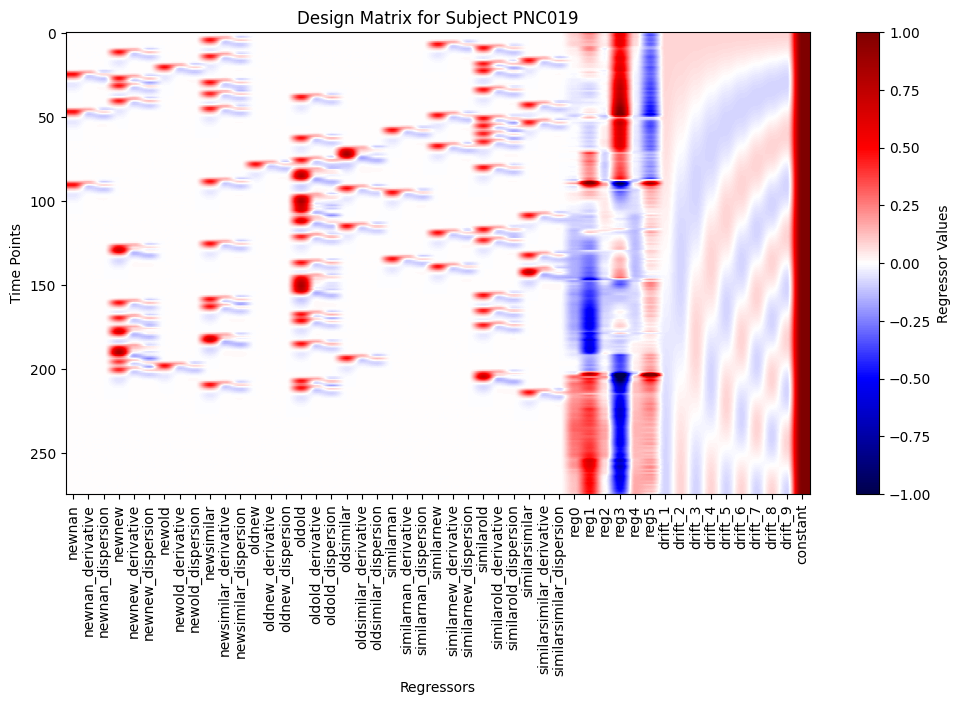

In [6]:
# plot design matrix (of the last subject, as an example)
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 1.1 Plot contrasts to surfaces 

/export03/data/opt/venv/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


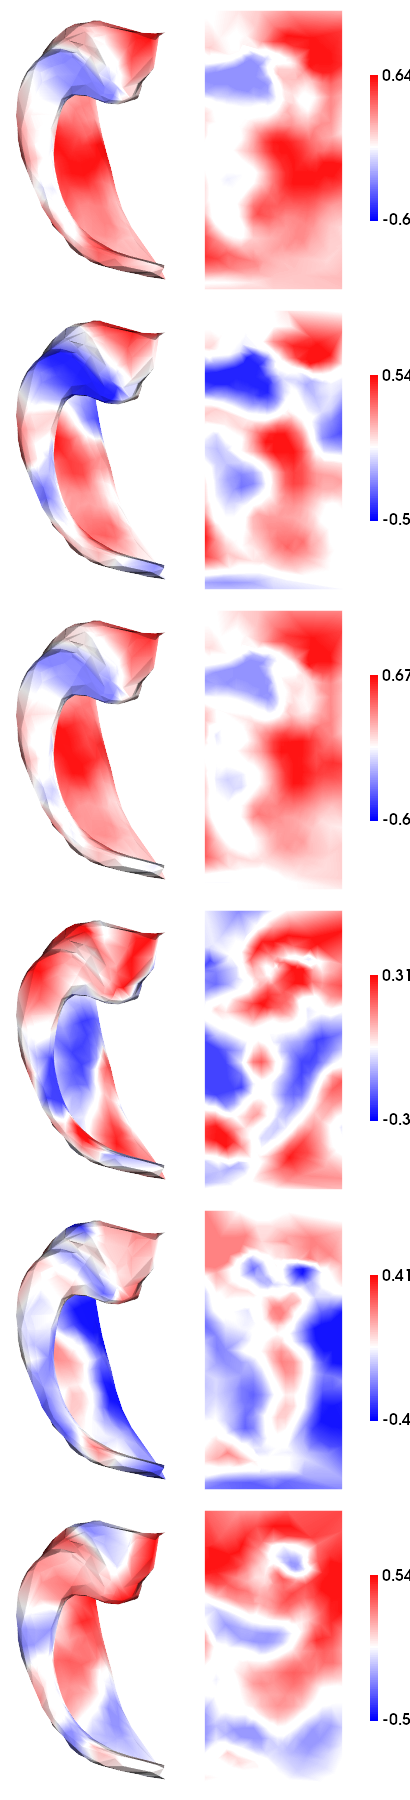

In [7]:
#compute average across subjects and hemispheres for each contrasts and plot hippocampal findings 

hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_patternsep2,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

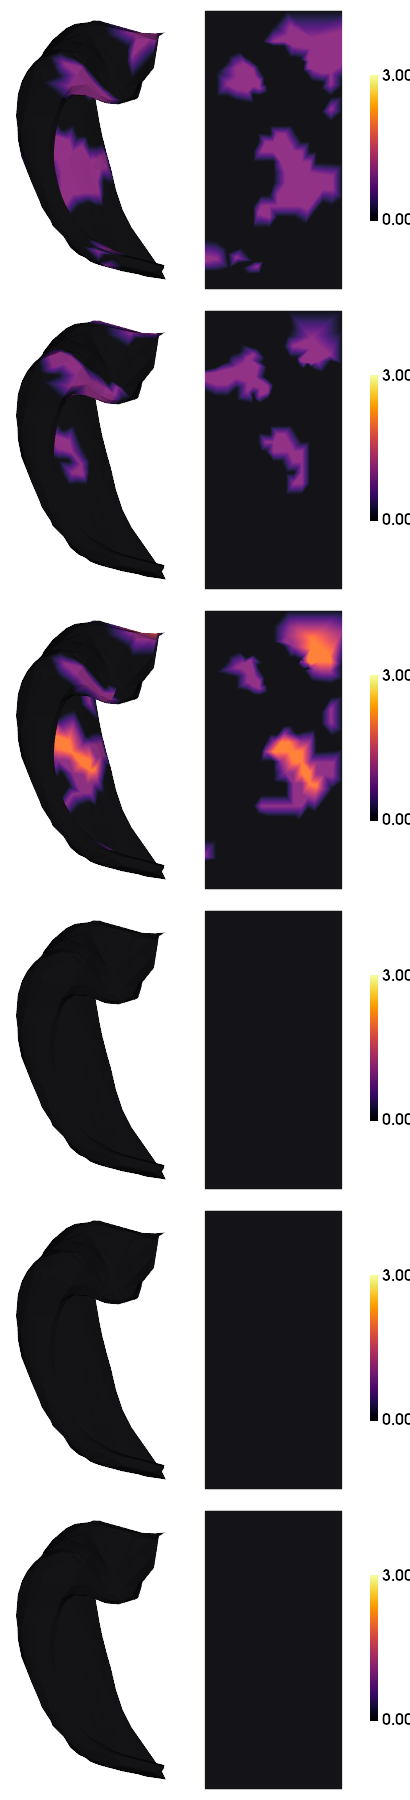

In [8]:
t = ttest_1samp(contrasts_patternsep2.reshape((nV,2*len(subs),contrasts_patternsep2.shape[-1])),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [9]:
#save the average maps
!mkdir -p ../../maps/HippoMaps-initializationMaps/Dataset-PNI
for l,label in enumerate(labels): 
    for c,contrast in enumerate(list(contrasts.keys())):
        cdat = np.nanmean(contrasts_patternsep2[iV[l],:,:,c],axis=(1,2)).flatten()
        data_array = nib.gifti.GiftiDataArray(data=cdat.astype(np.float32))
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-tfMRI-MST2_average-20_hemi-mix_den-2mm_label-{label}_contrast-{contrast}.shape.gii')

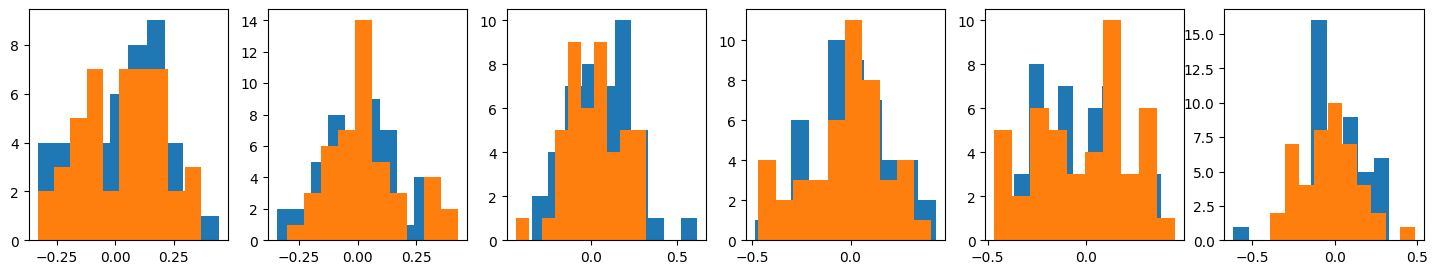

In [10]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(list(contrasts.keys()))))
fig, ax = plt.subplots(nrows=1, ncols=len(list(contrasts.keys())), figsize=(3*len(list(contrasts.keys())),3))
for h,hemi in enumerate(hemis):
    for c,contrast in enumerate(list(contrasts.keys())):
        cdat = contrasts_patternsep2[:,h,:,c].reshape((nV,-1))
        corr[:,:,h,c] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,c][np.triu_indices(len(subs),k=1)]
        ax[c].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

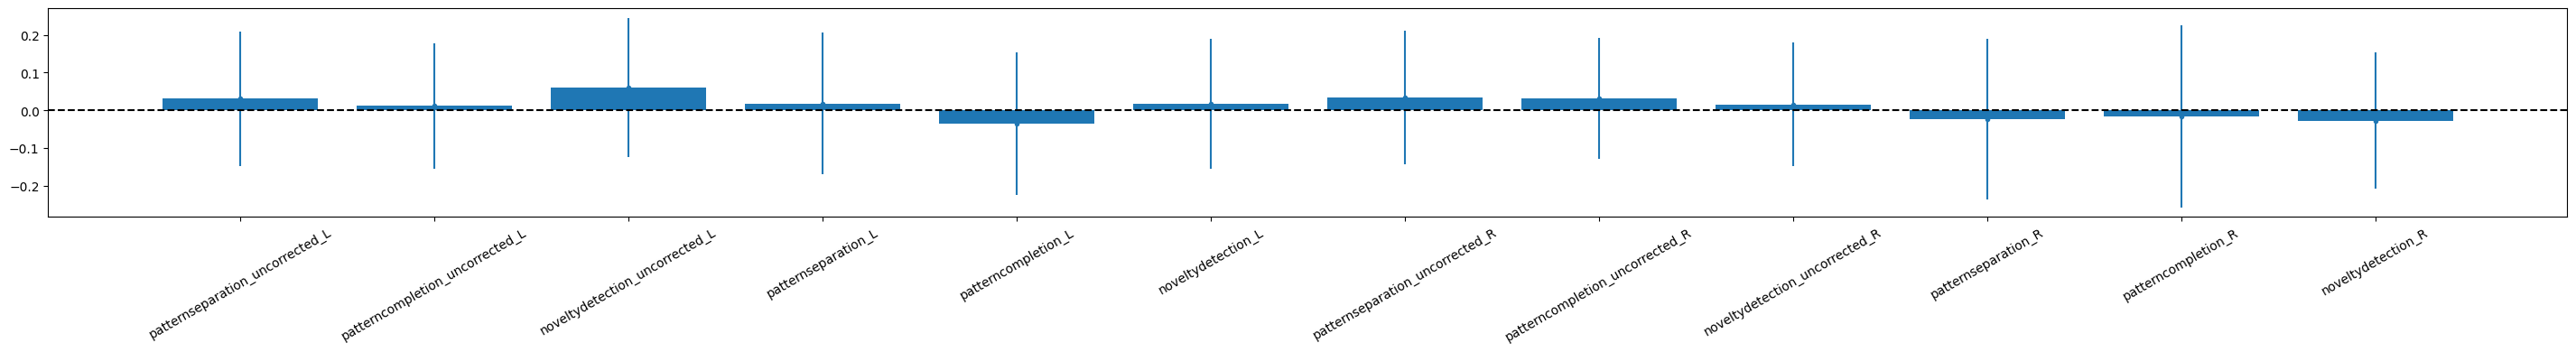

In [11]:
xnames = [s + "_L" for s in list(contrasts.keys())] + [s + "_R" for s in list(contrasts.keys())]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')

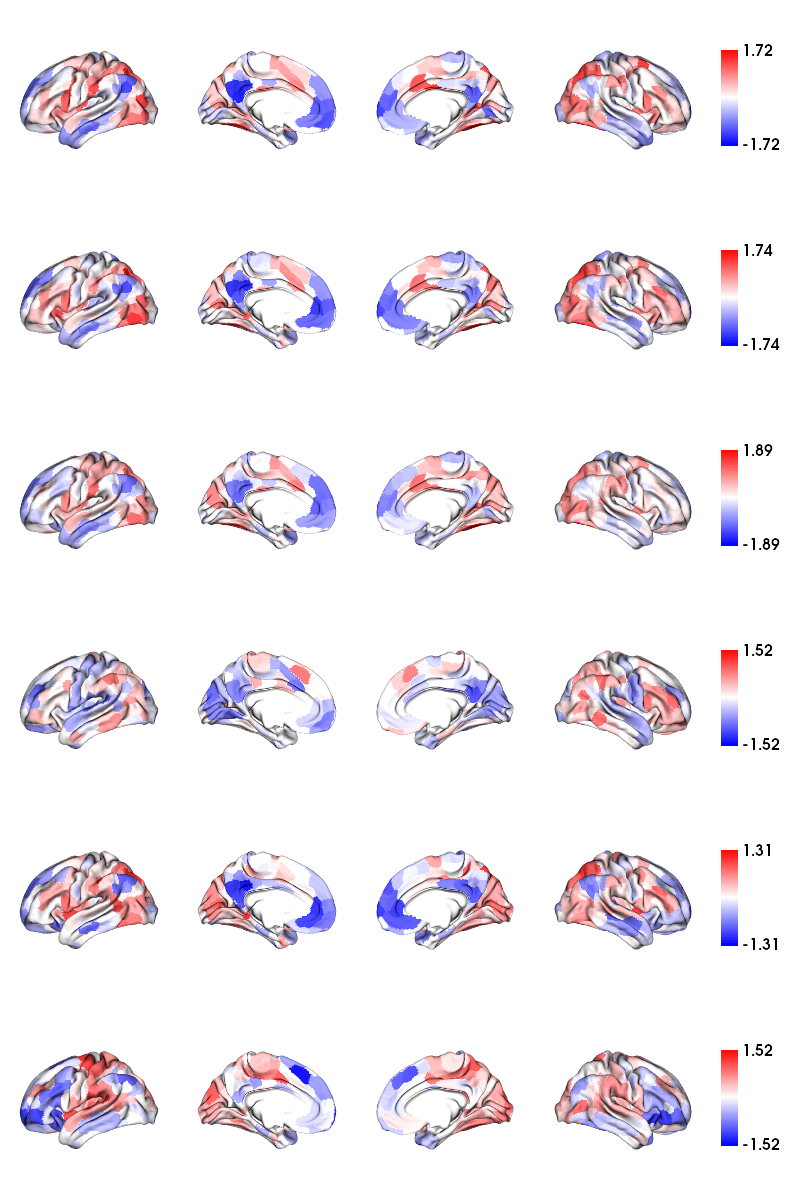

In [12]:
a=np.nanmean(contrasts_patternsep2_neo,axis=2)
reshaped_a = a.reshape(a.shape[0]* a.shape[1] , a.shape[2])
mapped_data = []
for i in range(reshaped_a.shape[1]):
    mapped = map_to_labels(reshaped_a[:, i], parc, fill=np.nan, mask=parc!=0)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh, array_name=mapped_data,
                 size=(800,200*len(mapped_data)), color_bar=True, cmap='bwr', color_range='sym', embed_nb=True, nan_color=(1, 1, 1, 1))

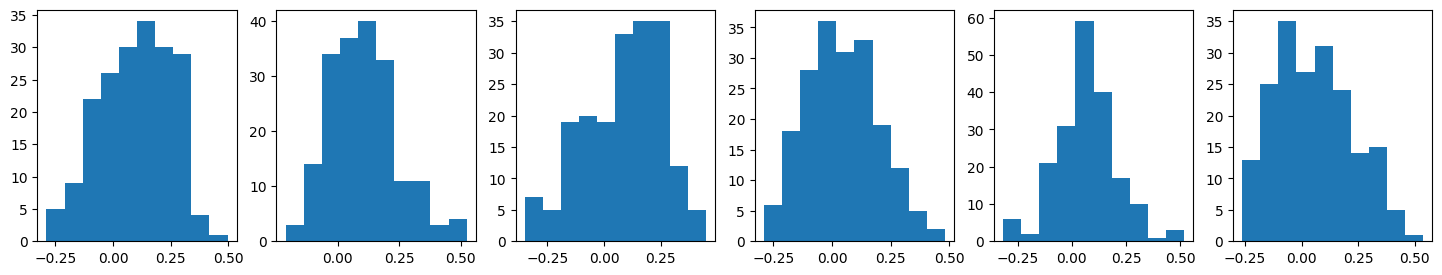

In [13]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(list(contrasts.keys()))))
fig, ax = plt.subplots(nrows=1, ncols=len(list(contrasts.keys())), figsize=(3*len(list(contrasts.keys())),3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_patternsep2_neo[:,:,:,f].reshape((200,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

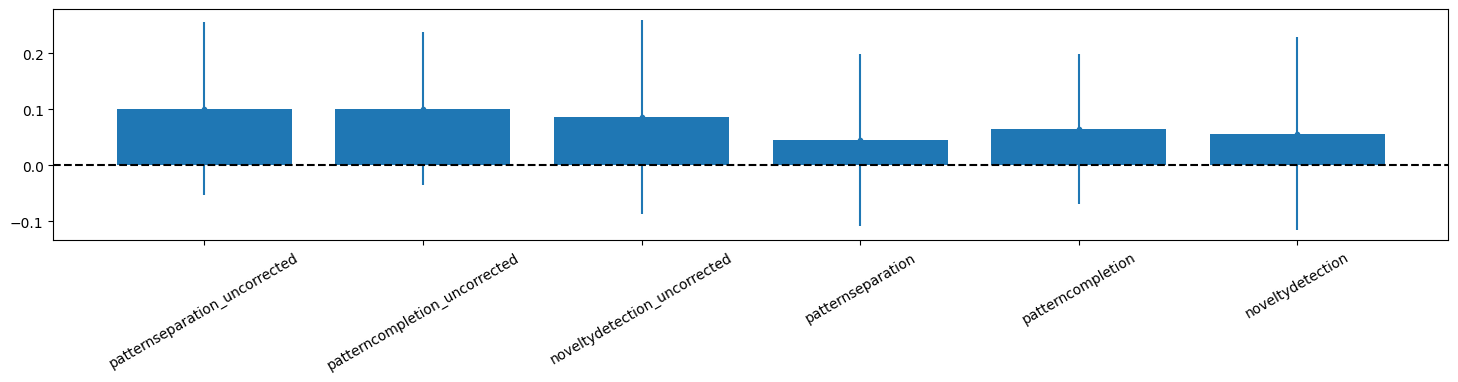

In [14]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(list(contrasts.keys())),3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

# 2.0 GLM fit for episodic retrieval

In [ ]:
contrasts_epiretrieve = np.ones((nV, len(hemis), len(subs), 2))*np.nan # 2 different contrasts will be considered
contrasts_epiretrieve_neo = np.ones((nP, len(hemis), len(subs), 2)) * np.nan

conditions = ['remembered', 'forgotten']
t = 2 # second task

for s,sub in enumerate(subs):
    
    # Specify the timing of fmri frames 
    motion_reg = all_motion_reg[t,s]
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)
    events = all_events[t,s]
    # Recode events to include fixation, stimulus, key press/response to soak up variance
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time','accuracy']]
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress','accuracy': 'trial_type'}, inplace=True)
    # Recode accuracy 
    mapping = {0: 'forgotten', 1: 'remembered'}
    df['trial_type'] = df['trial_type'].replace(mapping)

    
    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg
                                                  )
    # in case of some trial types missing, add extras with all 0sL
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0    
            
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
    'retrieval_uncorrected': (
        basic_contrasts['remembered']
        + basic_contrasts['remembered_derivative']
        + basic_contrasts['remembered_dispersion']),
    'retrieval_corrected': (
        basic_contrasts['remembered']
        - basic_contrasts['forgotten']
        + basic_contrasts['remembered_derivative']
        - basic_contrasts['forgotten_derivative']
        + basic_contrasts['remembered_dispersion']
        + basic_contrasts['forgotten_dispersion'])}
    
    for h, hemi in enumerate(hemis):

        ### fit the design matrix to the data
        labels_, estimates = run_glm(cdata_hipp[:,h,:210,t,s].T, design_matrix.values[:210]) # the last part of the task block is simply rest, so we will cut it
        labels_neo, estimates_neo = run_glm(neo_ts[:,h,:210,t,s].T, design_matrix.values[:210]) # the last part of the task block is simply rest, so we will cut it

        ### run contrasts of interest
        for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
            contrasts_epiretrieve[:, h, s, c] = contrast.z_score()
            contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
            contrasts_epiretrieve_neo[:, h, s, c] = contrast.z_score()


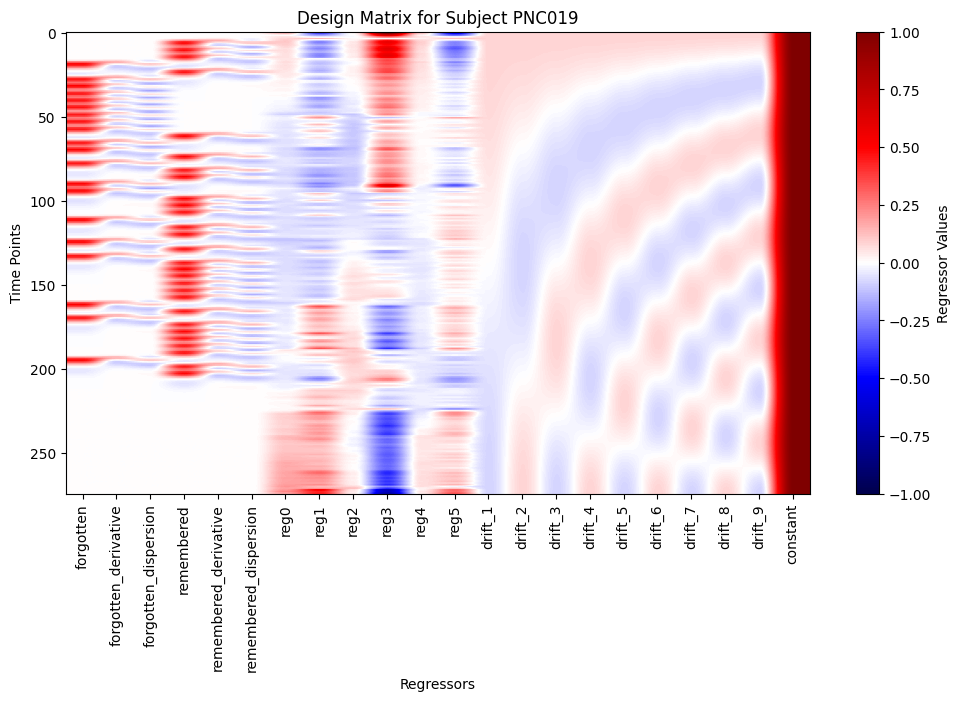

In [16]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 2.1 Plot to surfaces

/export03/data/opt/venv/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


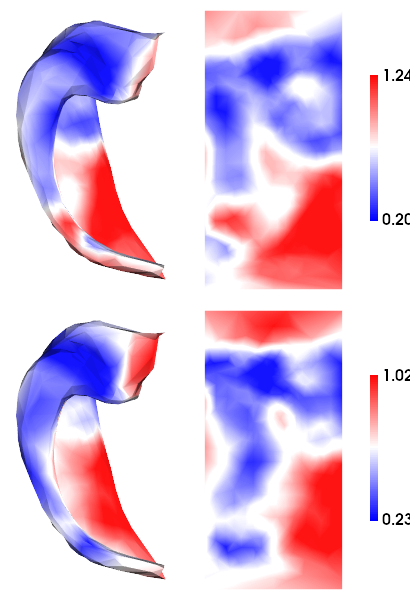

In [17]:
#compute average across subjects and hemispheres for each contrasts and plot hippocampal findings 
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiretrieve,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

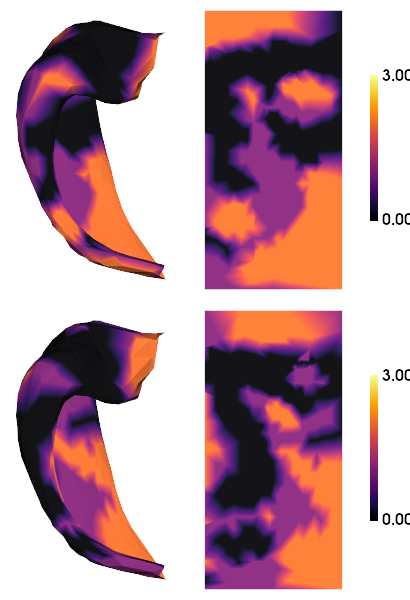

In [18]:
t = ttest_1samp(contrasts_epiretrieve.reshape((nV,2*len(subs),contrasts_epiretrieve.shape[-1])),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [19]:
#save the average maps
!mkdir -p ../../maps/HippoMaps-initializationMaps/Dataset-PNI
for l,label in enumerate(labels): 
    for c,contrastname_epiretrieve in enumerate(list(contrasts.keys())):
        cdat = np.nanmean(contrasts_epiretrieve[iV[l],:,:,c],axis=(1,2)).flatten()
        data_array = nib.gifti.GiftiDataArray(data=cdat.astype(np.float32))
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-tfMRI-epiretrieve_average-20_hemi-mix_den-2mm_label-{label}_contrast-{contrastname_epiretrieve}.shape.gii')

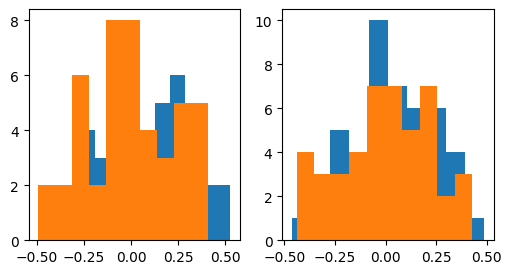

In [20]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(list(contrasts.keys()))))
fig, ax = plt.subplots(nrows=1, ncols=len(list(contrasts.keys())), figsize=(3*len(list(contrasts.keys())),3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(list(contrasts.keys())):
        cdat = contrasts_epiretrieve[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

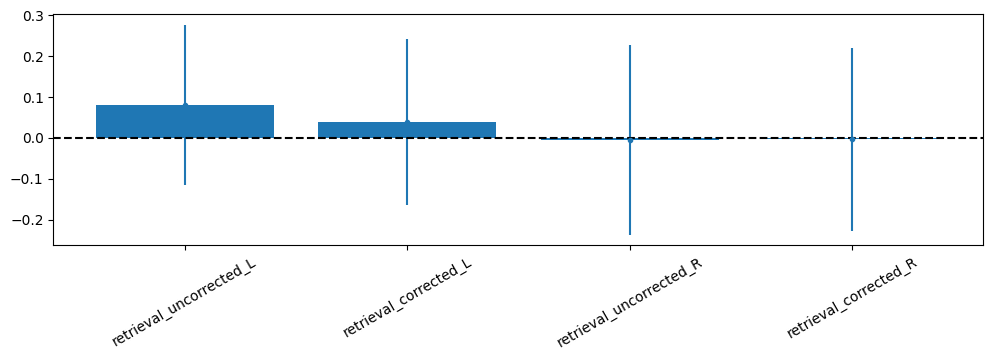

In [21]:
xnames = [s + "_L" for s in list(contrasts.keys())] + [s + "_R" for s in list(contrasts.keys())]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

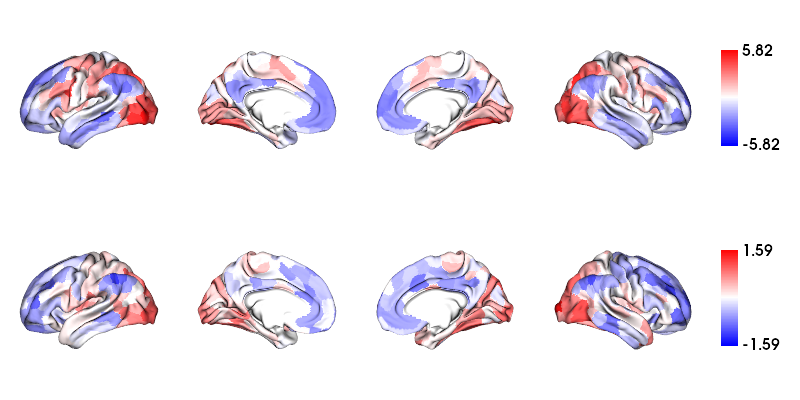

In [22]:
a=np.nanmean(contrasts_epiretrieve_neo,axis=2)
reshaped_a = a.reshape(a.shape[0]* a.shape[1] , a.shape[2])
# vertices to parcels
mapped_data = []
for i in range(reshaped_a.shape[1]):
    mapped = map_to_labels(reshaped_a[:, i], parc, fill=np.nan, mask=parc!=0)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh, array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, cmap='bwr', color_range='sym', embed_nb=True, nan_color=(1, 1, 1, 1))

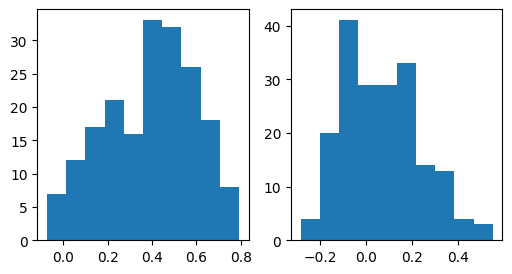

In [23]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(list(contrasts.keys()))))
fig, ax = plt.subplots(nrows=1, ncols=len(list(contrasts.keys())), figsize=(3*len(list(contrasts.keys())),3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_epiretrieve_neo[:,:,:,f].reshape((200,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

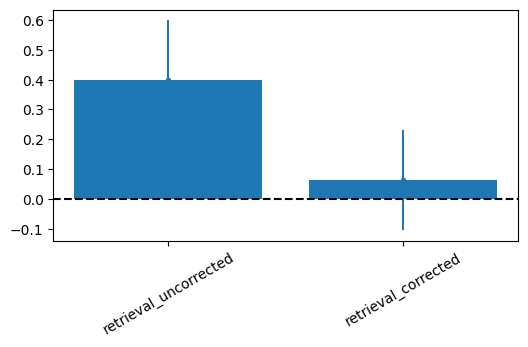

In [24]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(list(contrasts.keys())),3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

# 3. GLM fit for episodic encoding -subsequent memory 

In [ ]:
contrasts_epiencode = np.ones((nV, len(hemis), len(subs), 2))*np.nan # 2 different contrasts will be considered
contrasts_epiencode_neo = np.ones((nP, len(hemis), len(subs), 2)) * np.nan

conditions = ['correct', 'incorrect']
current_task='epiencode'
t = 1 # second task

for s,sub in enumerate(subs):
    
    # Specify the timing of fmri frames 
    motion_reg = all_motion_reg[t,s]
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # events here are more complicated, since we need to know which trials during encoded were actually remmebered at retrieval:
    # Load encoding file
    df_encode = all_events[t,s]
    df_encode= df_encode[['event_1_onset','event_1_duration','event_2_onset', 'stim_dur','stim_1','stim_2']]
    df_encode.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'stim_dur': 'duration'}, inplace=True)
    # Load retrieval file
    df_retrieve = all_events[2][s]
    df_retrieve=df_retrieve[['event_1_onset', 'event_1_duration', 'event_2_onset', 'event_2_duration', 'prime', 'target', 'accuracy', 'event_3_onset']]
    df_retrieve.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur', 'event_2_onset': 'onset', 'event_2_duration': 'duration', 'event_3_onset': 'keypress','accuracy': 'trial_type'}, inplace=True)
    mapping = {0: 'incorrect', 1: 'correct'}
    df_retrieve['trial_type'] = df_retrieve['trial_type'].replace(mapping)

    new_df = pd.DataFrame(columns=['onset','duration','prime','target','trial_type'])
    # Dictionary to keep track of matched rows in df_retrieve
    matched_rows_dict = {}

    # Iterate through rows in encoding data
    i=0
    for index, row_encode in df_encode.iterrows():
        stim_1 = row_encode['stim_1']
        stim_2 = row_encode['stim_2']

        # Check if this pair has already been matched
        if (stim_1, stim_2) not in matched_rows_dict:
            # Match rows in retrieval data based on stim_1 and stim_2
            match_rows = df_retrieve[(df_retrieve['prime'] == stim_1) & (df_retrieve['target'] == stim_2)]

            # If there is exactly one match, append the data to the design matrix
            if len(match_rows) == 1:
                matched_row = match_rows.iloc[0]
                new_df.loc[i] = [row_encode['onset'],
                                 row_encode['duration'],
                                 matched_row['prime'],
                                 matched_row['target'],
                                 matched_row['trial_type']]
                i+=1
                # Update the matched_rows_dict to mark this pair as matched
                matched_rows_dict[(stim_1, stim_2)] = True
            else:
                # If there is no match or multiple matches, mark this pair as unmatched
                matched_rows_dict[(stim_1, stim_2)] = False

    design_matrix = make_first_level_design_matrix(frame_times,
                                      events=new_df,
                                      hrf_model='spm + derivative + dispersion',
                                      add_regs=motion_reg)
    for condition in conditions:
        if condition not in design_matrix.columns:
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
                    'subsequent_memory_uncorrected': (
                        basic_contrasts['correct']
                        + basic_contrasts['correct_derivative']
                        + basic_contrasts['correct_dispersion']),
                    'subsequent_memory_corrected': (
                        basic_contrasts['correct']
                        - basic_contrasts['incorrect']
                        + basic_contrasts['correct_derivative']
                        - basic_contrasts['incorrect_derivative']
                        + basic_contrasts['correct_dispersion']
                        - basic_contrasts['incorrect_dispersion'])}           

    for h, hemi in enumerate(hemis):

        ### fit the design matrix to the data
        labels_, estimates = run_glm(cdata_hipp[:,h,:210,t,s].T, design_matrix.values[:210]) # the last part of the task block is simply rest, so we will cut it
        labels_neo, estimates_neo = run_glm(neo_ts[:,h,:210,t,s].T, design_matrix.values[:210]) # the last part of the task block is simply rest, so we will cut it

        ### run contrasts of interest
        for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
            contrasts_epiencode[:, h, s, c] = contrast.z_score()
            contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
            contrasts_epiencode_neo[:, h, s, c] = contrast.z_score()

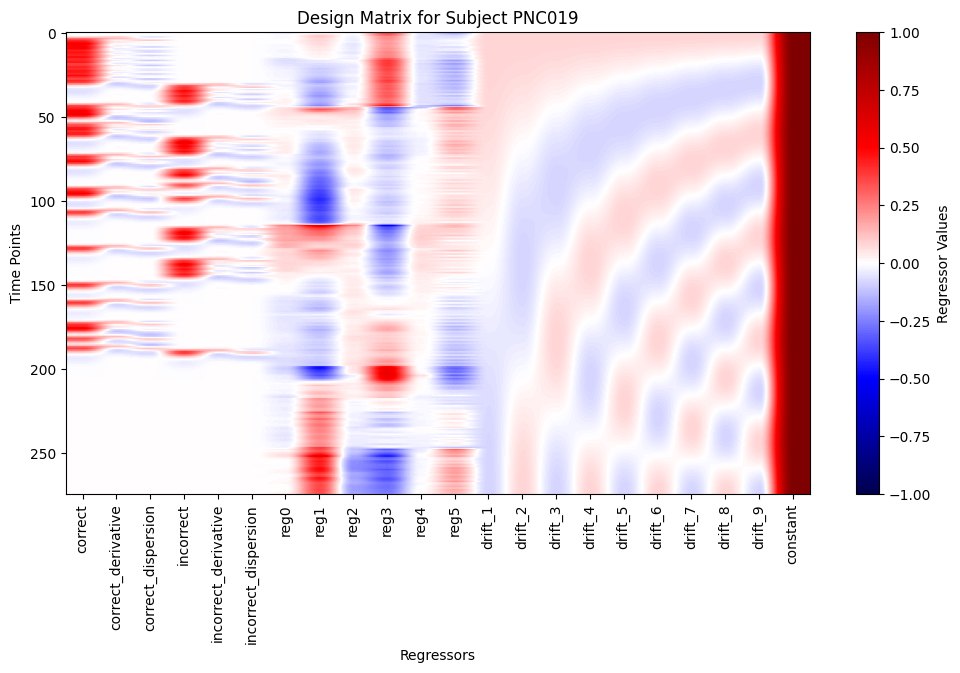

In [26]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 3.1 Plot to surfaces 

/export03/data/opt/venv/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


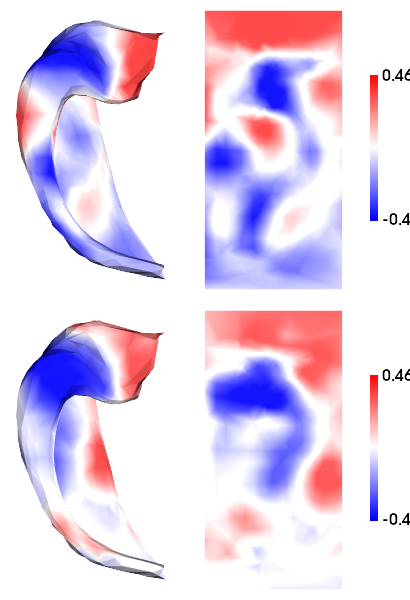

In [27]:
#compute average across subjects and hemispheres for each contrasts and plot hippocampal findings 
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiencode,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

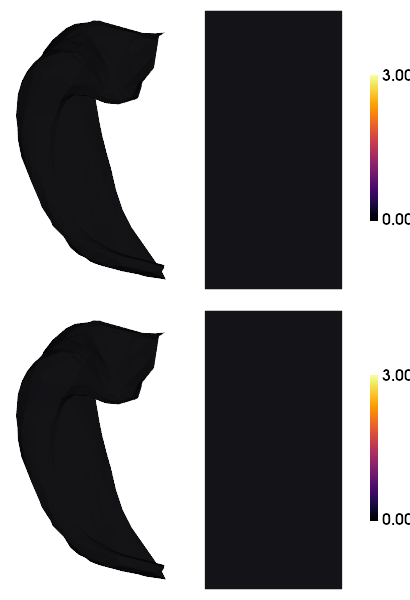

In [28]:
t = ttest_1samp(contrasts_epiencode.reshape((nV,2*len(subs),contrasts_epiencode.shape[-1])),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [29]:
#save the average maps
!mkdir -p ../../maps/HippoMaps-initializationMaps/Dataset-PNI
for l,label in enumerate(labels): 
    for c,contrastname_epiencode in enumerate(list(contrasts.keys())):
        cdat = np.nanmean(contrasts_epiencode[iV[l],:,:,c],axis=(1,2)).flatten()
        data_array = nib.gifti.GiftiDataArray(data=cdat.astype(np.float32))
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-tfMRI-epiencode_average-20_hemi-mix_den-2mm_label-{label}_contrast-{contrastname_epiencode}.shape.gii')

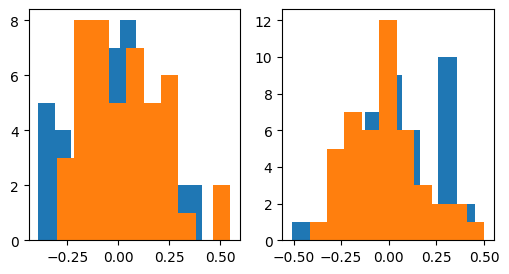

In [30]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(list(contrasts.keys()))))
fig, ax = plt.subplots(nrows=1, ncols=len(list(contrasts.keys())), figsize=(3*len(list(contrasts.keys())),3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(list(contrasts.keys())):
        cdat = contrasts_epiencode[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

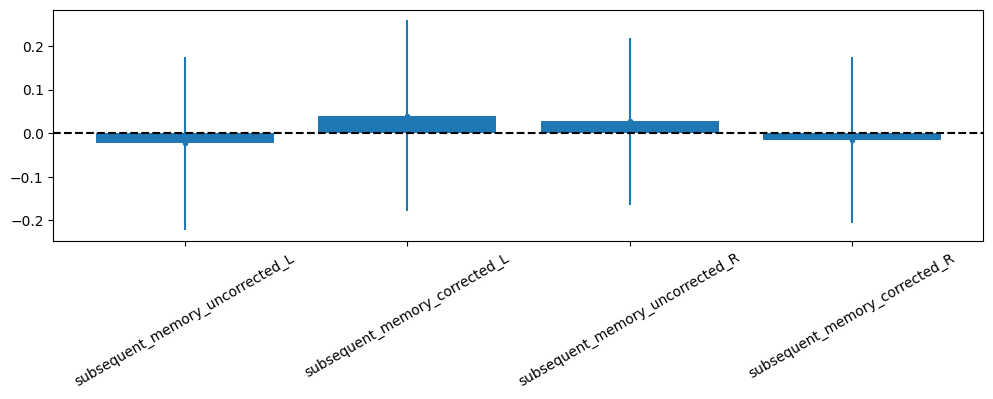

In [31]:
xnames = [s + "_L" for s in list(contrasts.keys())] + [s + "_R" for s in list(contrasts.keys())]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

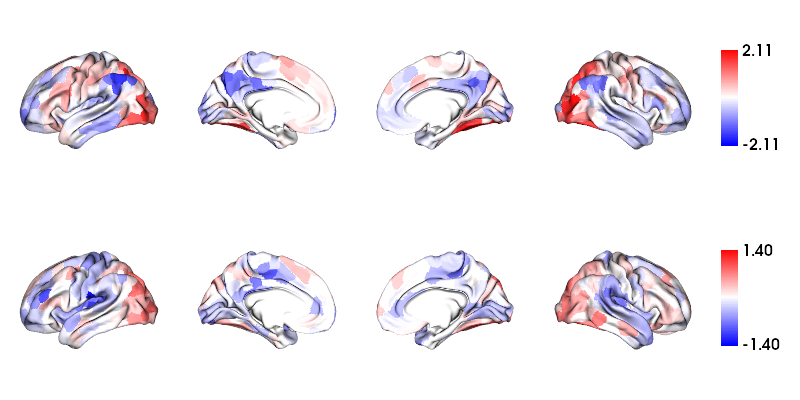

In [32]:
a=np.nanmean(contrasts_epiencode_neo,axis=2)
reshaped_a = a.reshape(a.shape[0]* a.shape[1] , a.shape[2])
# vertices to parcels
mapped_data = []
for i in range(reshaped_a.shape[1]):
    mapped = map_to_labels(reshaped_a[:, i], parc, fill=np.nan, mask=parc!=0)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh, array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, cmap='bwr', color_range='sym', embed_nb=True, nan_color=(1, 1, 1, 1))

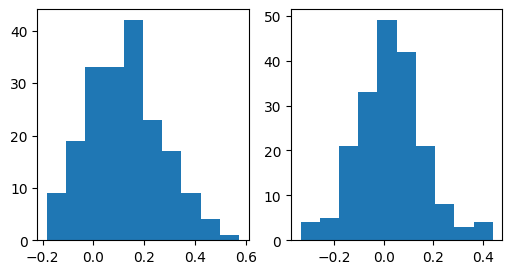

In [33]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(list(contrasts.keys()))))
fig, ax = plt.subplots(nrows=1, ncols=len(list(contrasts.keys())), figsize=(3*len(list(contrasts.keys())),3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_epiencode_neo[:,:,:,f].reshape((200,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

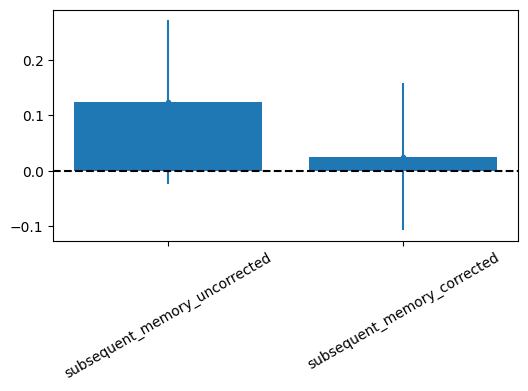

In [34]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(list(contrasts.keys())),3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);